# Conclave Simulation Analysis

This notebook analyzes the results of the conclave simulation, focusing on how temperature and agent rationality affect consensus, polarization, and gridlock.


# 📓 Conclave‐Dynamics Notebook

## 0. Imports & Helpers

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## 1. Load Data

In [2]:
ballot_df = pd.read_csv('../results/combined_ballots.csv')
results_df = pd.read_csv('../results/combined_results_snellius.csv')

In [3]:
ballot_df['run_id'] = ballot_df['run_id'].astype(str)
results_df['run_id'] = results_df['run_id'].astype(str)

In [9]:

# Clean up candidate_voted_for column
# The pivot table operation requires column values to be hashable (e.g., strings, numbers).
# This ensures that any list-like or array-like data is converted to a string representation.
ballot_df['candidate_voted_for'] = ballot_df['candidate_voted_for'].apply(lambda x: str(x) if isinstance(x, (list, np.ndarray)) else x)


## 1. Early-Leader Detection

In [10]:
def get_vote_share_pivot(df):
    """Computes vote share pivot table: share[(run_id, round)][candidate]."""
    return df.pivot_table(
        index=['run_id', 'round'],
        columns='candidate_voted_for',
        values='agent_id',
        aggfunc='count'
    ).fillna(0)

def normalise_vote_share(pivot_table):
    """Normalises vote share by the total number of votes in each round."""
    return pivot_table.div(pivot_table.sum(axis=1), axis=0)

In [11]:
def find_early_leader(run_share, num_candidates):
    """Finds the first round where a candidate's share exceeds a threshold and never dips below."""
    threshold = 1 / num_candidates + 0.05
    for round_num in run_share.index:
        round_shares = run_share.loc[round_num]
        potential_leaders = round_shares[round_shares >= threshold]
        for candidate in potential_leaders.index:
            if (run_share.loc[round_num:][candidate] >= threshold).all():
                return round_num, candidate
    return None, None

In [17]:
%%time

vote_share_pivot = get_vote_share_pivot(ballot_df)
vote_share_pivot_normalised = normalise_vote_share(vote_share_pivot)

early_leader_data = []
for run_id, run_df in vote_share_pivot_normalised.groupby(level='run_id'):
    num_candidates = len(run_df.columns)
    # find_early_leader returns a tuple (round_num, candidate_id)
    # where round_num can itself be a tuple (run_id, round) from the MultiIndex
    early_lead_info, early_leader_id = find_early_leader(run_df, num_candidates)
    
    # Extract only the round number if it's a tuple
    early_lead_round = early_lead_info[1] if early_lead_info is not None else None

    run_params = ballot_df[ballot_df['run_id'] == run_id].iloc[0]
    early_leader_data.append({
        'run_id': run_id,
        'early_lead_round': early_lead_round,
        'early_leader_id': early_leader_id,
        'temperature': run_params['temperature'],
        'rationality': run_params['rationality']
    })

early_leader_df = pd.DataFrame(early_leader_data)

CPU times: user 27.7 s, sys: 246 ms, total: 27.9 s
Wall time: 28 s


In [18]:
early_leader_df

,run_id,early_lead_round,early_leader_id,temperature,rationality
0,temp_0_10_rat_0_00_10_run_13_spoulain1,1.0,Luis Antonio Gokim Tagle,0.1,0.0
1,temp_0_10_rat_0_00_11_run_13_spoulain,1.0,Luis Antonio Gokim Tagle,0.1,0.0
2,temp_0_10_rat_0_00_12_run_14_spoulain,1.0,Luis Antonio Gokim Tagle,0.1,0.0
3,temp_0_10_rat_0_00_13_run_15_spoulain,1.0,Luis Antonio Gokim Tagle,0.1,0.0
4,temp_0_10_rat_0_00_14_run_16_spoulain1,1.0,Luis Antonio Gokim Tagle,0.1,0.0
...,...,...,...,...,...
1270,temp_2_00_rat_1_00_5_run_14_ehazbolatow,1.0,Luis Antonio Gokim Tagle,2.0,1.0
1271,temp_2_00_rat_1_00_6_run_15_ehazbolatow,1.0,Luis Antonio Gokim Tagle,2.0,1.0
1272,temp_2_00_rat_1_00_7_run_16_ehazbolatow,1.0,Luis Antonio Gokim Tagle,2.0,1.0
1273,temp_2_00_rat_1_00_8_run_17_ehazbolatow,1.0,Luis Antonio Gokim Tagle,2.0,1.0


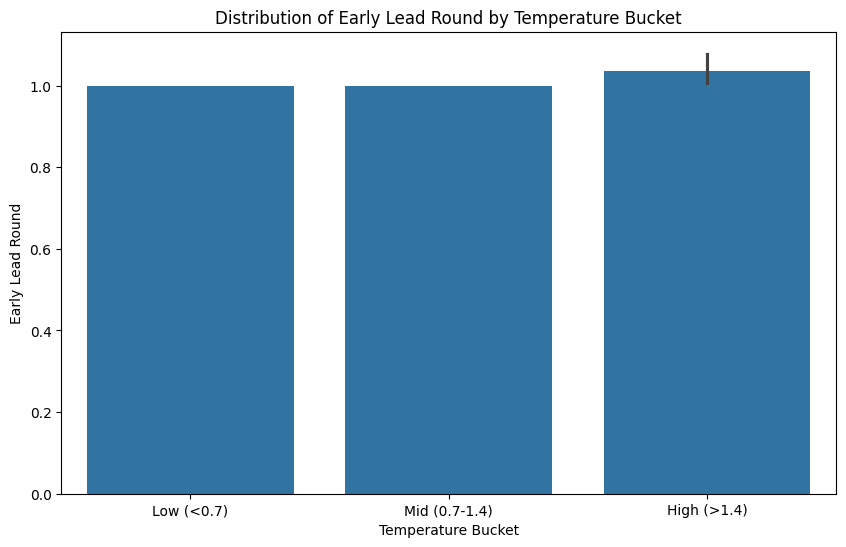

In [20]:
def bucket_temperature(temp):
    if temp < 0.7:
        return 'Low (<0.7)'
    elif temp <= 1.4:
        return 'Mid (0.7-1.4)'
    else:
        return 'High (>1.4)'

early_leader_df['temp_bucket'] = early_leader_df['temperature'].apply(bucket_temperature)

plt.figure(figsize=(10, 6))
sns.barplot(
    data=early_leader_df.dropna(subset=['early_lead_round']),
    x='temp_bucket',
    y='early_lead_round',
    order=['Low (<0.7)', 'Mid (0.7-1.4)', 'High (>1.4)']
)
plt.title('Distribution of Early Lead Round by Temperature Bucket')
plt.xlabel('Temperature Bucket')
plt.ylabel('Early Lead Round')
plt.show()

## 2. Vote-Switch Volatility

In [23]:
%%time

ballot_df['switched'] = ballot_df.groupby(['run_id', 'agent_id'])['candidate_voted_for'].transform(lambda x: x.ne(x.shift()))

volatility = ballot_df.groupby(['run_id', 'round'])['switched'].mean().reset_index()
volatility.rename(columns={'switched': 'volatility'}, inplace=True)

volatility_summary = volatility.groupby('run_id').agg(
    mean_vol=('volatility', 'mean'),
    max_vol=('volatility', 'max'),
    final2=('volatility', lambda x: x.tail(2).mean())
).reset_index()

# Merge with params
volatility_summary = pd.merge(volatility_summary, early_leader_df[['run_id', 'temperature', 'rationality']], on='run_id')

CPU times: user 4.98 s, sys: 120 ms, total: 5.1 s
Wall time: 5.12 s


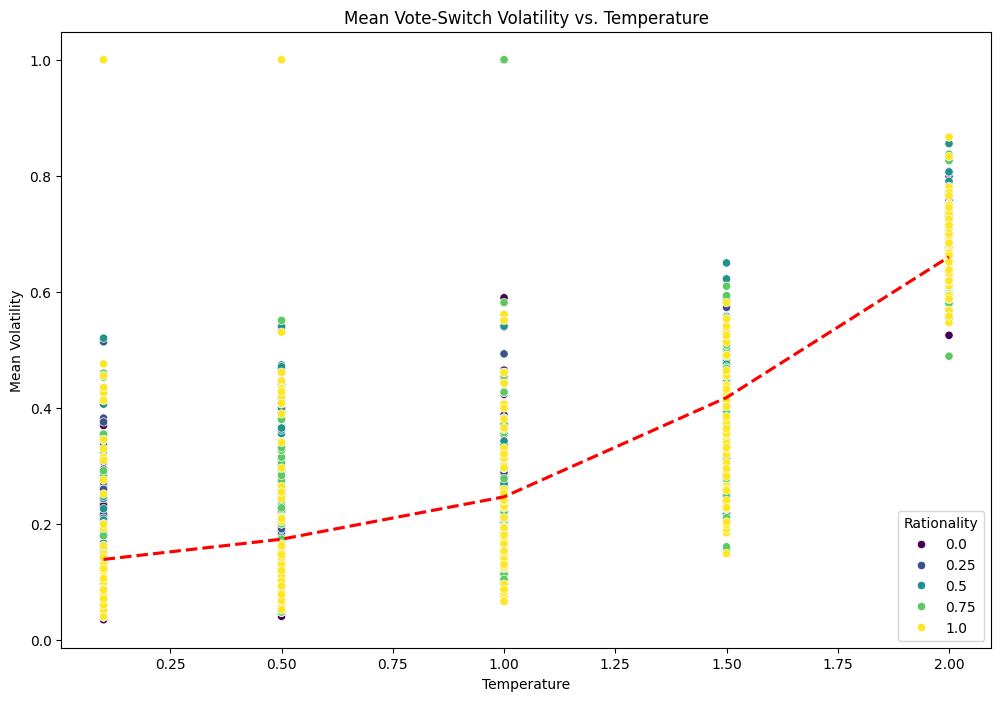

In [24]:
plt.figure(figsize=(12, 8))
sns.scatterplot(data=volatility_summary, x='temperature', y='mean_vol', hue='rationality', palette='viridis')
sns.regplot(data=volatility_summary, x='temperature', y='mean_vol', scatter=False, lowess=True, line_kws={'color': 'red', 'ls': '--'})

plt.title('Mean Vote-Switch Volatility vs. Temperature')
plt.xlabel('Temperature')
plt.ylabel('Mean Volatility')
plt.legend(title='Rationality')
plt.show()

## 3. ENOC Curve (Effective Number of Candidates)

In [ ]:
%%time

def calculate_enoc(df):
    """Calculates the Effective Number of Candidates (ENOC) for each round."""
    enoc = 1 / (df**2).sum(axis=1)
    enoc.name = 'enoc'
    return enoc

enoc_series = calculate_enoc(vote_share_pivot_normalised)
enoc_df = enoc_series.reset_index()

def get_time_to_enoc2(enoc_run_series):
    """Finds the first round where ENOC is less than or equal to 2."""
    try:
        return enoc_run_series[enoc_run_series <= 2].index[0][1]
    except IndexError:
        return None

enoc_summary = enoc_df.groupby('run_id').agg(
    median_enoc=('enoc', 'median'),
    min_enoc=('enoc', 'min')
).reset_index()

time_to_enoc2_data = []
for run_id, run_df in enoc_df.set_index(['run_id', 'round']).groupby(level='run_id'):
    time_to_enoc2 = get_time_to_enoc2(run_df['enoc'])
    time_to_enoc2_data.append({'run_id': run_id, 'time_to_enoc2': time_to_enoc2})

time_to_enoc2_df = pd.DataFrame(time_to_enoc2_data)
enoc_summary = pd.merge(enoc_summary, time_to_enoc2_df, on='run_id')

print(enoc_summary.head())

                                   run_id  median_enoc  min_enoc  \
0  temp_0_10_rat_0_00_10_run_13_spoulain1     1.979390  1.828637   
1   temp_0_10_rat_0_00_11_run_13_spoulain     1.971609  1.574307   
2   temp_0_10_rat_0_00_12_run_14_spoulain     1.971609  1.814224   
3   temp_0_10_rat_0_00_13_run_15_spoulain     1.996933  1.808973   
4  temp_0_10_rat_0_00_14_run_16_spoulain1     2.046827  1.704142   

   time_to_enoc2  
0            2.0  
1            1.0  
2            6.0  
3            8.0  
4            4.0  
CPU times: user 148 ms, sys: 4.58 ms, total: 152 ms
Wall time: 151 ms


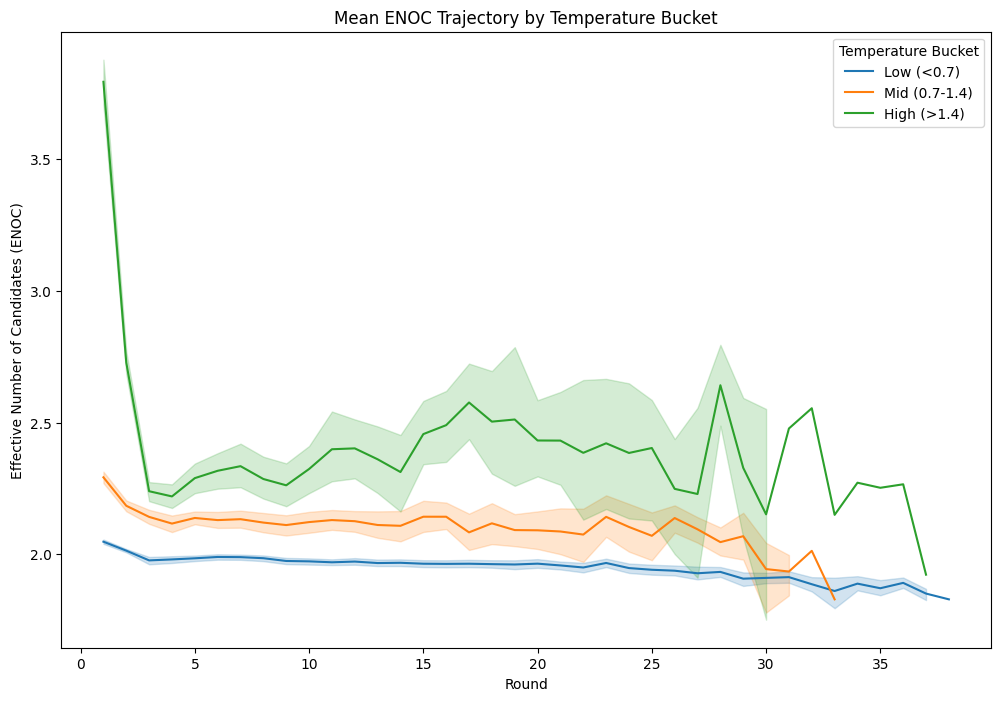

In [ ]:
enoc_df_with_params = pd.merge(enoc_df, early_leader_df[['run_id', 'temp_bucket']], on='run_id')

plt.figure(figsize=(12, 8))
sns.lineplot(data=enoc_df_with_params, x='round', y='enoc', hue='temp_bucket', hue_order=['Low (<0.7)', 'Mid (0.7-1.4)', 'High (>1.4)'])

plt.title('Mean ENOC Trajectory by Temperature Bucket')
plt.xlabel('Round')
plt.ylabel('Effective Number of Candidates (ENOC)')
plt.legend(title='Temperature Bucket')
plt.show()

## 4. Tipping-Point Finder

In [ ]:
def find_tipping_point(run_share):
    """Finds the tipping point for a given run."""
    for round_num, shares in run_share.iterrows():
        winner_candidate = shares[shares > 0.5]
        if not winner_candidate.empty:
            candidate_id = winner_candidate.index[0]
            # Check if the winner's share never drops below 0.4 afterwards
            if (run_share.loc[round_num:][candidate_id] >= 0.4).all():
                return round_num[1], candidate_id
    return None, None

In [ ]:
%%time

tipping_point_data = []
for run_id, run_df in vote_share_pivot_normalised.groupby(level='run_id'):
    tipping_round, winner_id = find_tipping_point(run_df)
    
    if tipping_round is not None:
        consensus_round = run_df.index.get_level_values('round').max()
        gap_to_consensus = consensus_round - tipping_round
    else:
        consensus_round = None
        gap_to_consensus = None

    run_params = ballot_df[ballot_df['run_id'] == run_id].iloc[0]
    tipping_point_data.append({
        'run_id': run_id,
        'tipping_round': tipping_round,
        'winner_id': winner_id,
        'consensus_round': consensus_round,
        'gap_to_consensus': gap_to_consensus,
        'temperature': run_params['temperature'],
        'rationality': run_params['rationality']
    })

tipping_point_df = pd.DataFrame(tipping_point_data)
print(tipping_point_df.head())

                                   run_id  tipping_round  \
0  temp_0_10_rat_0_00_10_run_13_spoulain1            2.0   
1   temp_0_10_rat_0_00_11_run_13_spoulain            2.0   
2   temp_0_10_rat_0_00_12_run_14_spoulain            5.0   
3   temp_0_10_rat_0_00_13_run_15_spoulain            4.0   
4  temp_0_10_rat_0_00_14_run_16_spoulain1            3.0   

                  winner_id  consensus_round  gap_to_consensus  temperature  \
0  Luis Antonio Gokim Tagle             10.0               8.0          0.1   
1  Luis Antonio Gokim Tagle              3.0               1.0          0.1   
2  Luis Antonio Gokim Tagle             25.0              20.0          0.1   
3  Luis Antonio Gokim Tagle             14.0              10.0          0.1   
4  Luis Antonio Gokim Tagle              4.0               1.0          0.1   

   rationality  
0          0.0  
1          0.0  
2          0.0  
3          0.0  
4          0.0  
CPU times: user 25 s, sys: 233 ms, total: 25.2 s
Wall time: 25

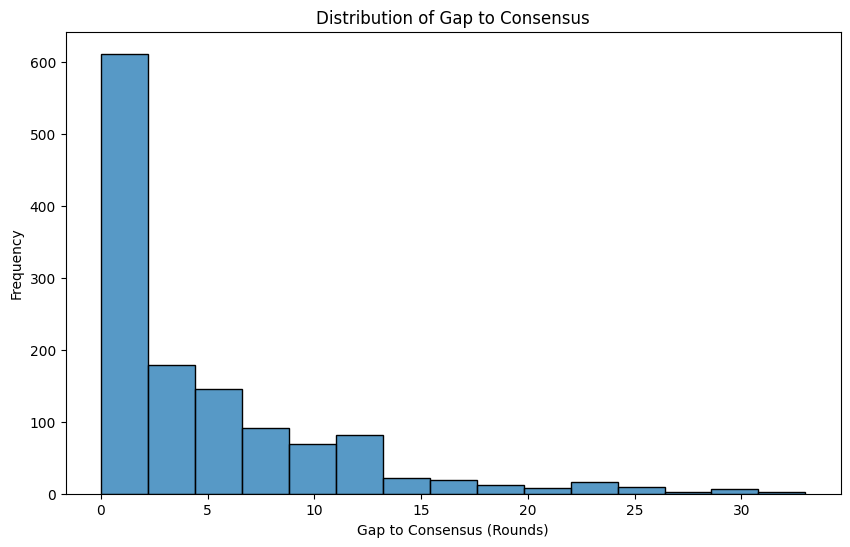

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(data=tipping_point_df.dropna(), x='gap_to_consensus', bins=15)
plt.title('Distribution of Gap to Consensus')
plt.xlabel('Gap to Consensus (Rounds)')
plt.ylabel('Frequency')
plt.show()

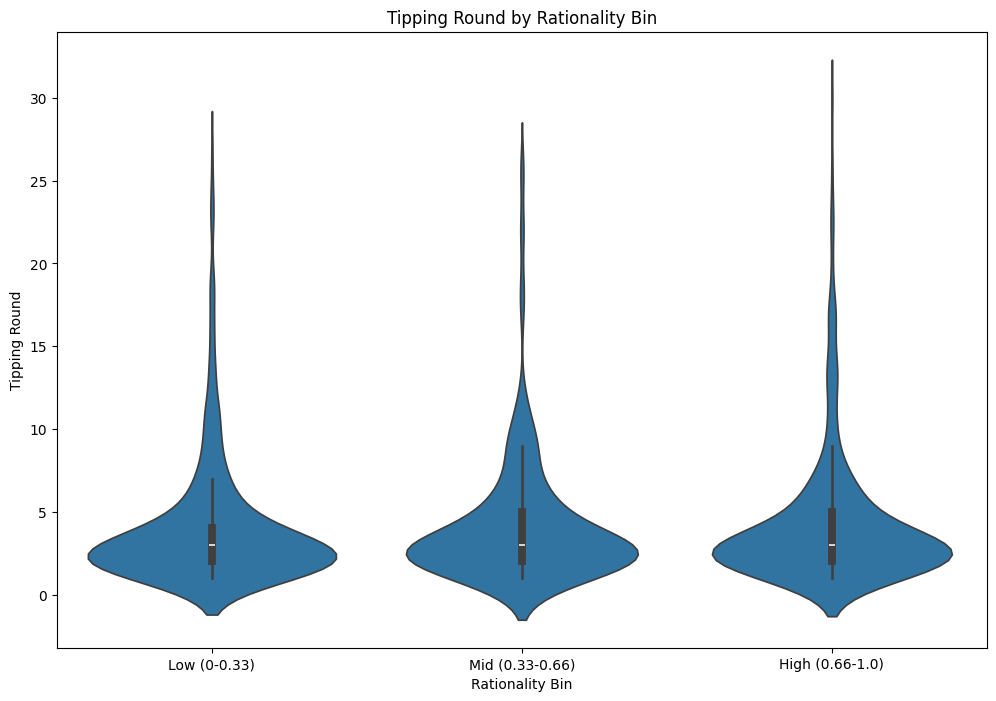

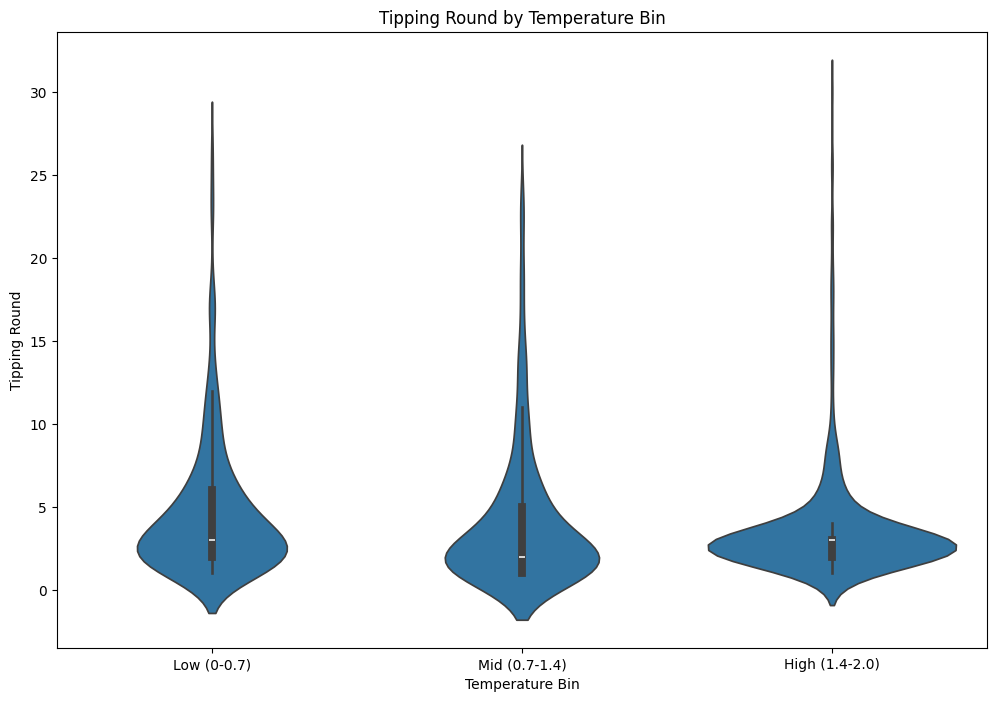

In [ ]:
tipping_point_df['rationality_bin'] = pd.cut(tipping_point_df['rationality'], bins=[0, 0.33, 0.66, 1.0], labels=['Low (0-0.33)', 'Mid (0.33-0.66)', 'High (0.66-1.0)'], include_lowest=True)
tipping_point_df['temperature_bin'] = pd.cut(tipping_point_df['temperature'], bins=[0, 0.7, 1.4, 2.0], labels=['Low (0-0.7)', 'Mid (0.7-1.4)', 'High (1.4-2.0)'], include_lowest=True)


plt.figure(figsize=(12, 8))
sns.violinplot(data=tipping_point_df.dropna(), x='rationality_bin', y='tipping_round')
plt.title('Tipping Round by Rationality Bin')
plt.xlabel('Rationality Bin')
plt.ylabel('Tipping Round')
plt.show()

plt.figure(figsize=(12, 8))
sns.violinplot(data=tipping_point_df.dropna(), x='temperature_bin', y='tipping_round')
plt.title('Tipping Round by Temperature Bin')
plt.xlabel('Temperature Bin')
plt.ylabel('Tipping Round')
plt.show()